In [ ]:
!pip install scikit-mobility

In [2]:
import skmob
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
try:
    import powerlaw
    import mpmath
except:
    !pip install powerlaw
    !pip install mpmath
    import mpmath
    import powerlaw
import scipy as sp
import geopy.distance
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

nodes=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment_4/THE_NODES.txt',
                  header=None, sep=" ",
                  names=['county ID', 'population', 'latitude', 'longitude', 'intra county trips'])

links=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment_4/THE_LINKS.txt',
                  header=None, sep=" ",
                  names=['origin county', 'destination county', 'distance [km]','number of trips'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# check import
display(nodes.head())
links[links['origin county']!=links['destination county']].groupby('destination county').sum().fillna(0)

,county ID,population,latitude,longitude,intra county trips
0,1001,43671,32.523283,-86.577176,7871
1,1003,140415,30.592781,-87.748260,45208
2,1005,29038,31.856515,-85.331312,8370
3,1007,20826,33.040054,-87.123243,3199
4,1009,51024,33.978461,-86.554768,8966


,origin county,distance [km],number of trips
destination county,,,
1001,253156,10738.316059,3748
1003,1108006,42098.776387,6990
1005,891947,17051.853009,3090
1007,94556,3005.565705,1099
1009,197722,4096.717616,2317
...,...,...,...
56037,2604379,48461.759792,1768
56039,1572847,47015.084145,2677
56041,944187,14599.011294,378


In [5]:
# remove the county that has only intra flows and inflows
nodes=(nodes[nodes['county ID']!=15005])
links=(links[links['origin county']!=15005])

In [6]:
fdf = links[['number of trips','origin county', 'destination county']].rename(columns={"number of trips":'flow', "origin county":'origin','destination county':'destination'})
fdf.head()

,flow,origin,destination
0,7871,1001,1001
1,7,1001,1007
2,37,1001,1013
3,5,1001,1015
4,350,1001,1021


#### Question 1 - Report the total number of outflows and inflows

These should match, which they do, and the number 34,116,820 does match between inflows and outflows + is reported below

In [7]:
tot_inflows =  fdf[fdf['origin'] != fdf['destination']].groupby('destination')['flow'].sum().fillna(0).values
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby('origin')['flow'].sum().values
display(tot_inflows, tot_outflows)

# make sure they match!
print(f"The total number of outflows is {sum(tot_outflows)} and the total number of inflows is {sum(tot_inflows)}")

array([3748, 6990, 3090, ...,  378,  296,  238])

array([11921, 16977,  1651, ...,  1512,   239,   514])

The total number of outflows is 34116820 and the total number of inflows is 34116820


#### Question 2 - What is the total population of the given set of counties?

The total population, printed below, is 281,421,759

In [8]:
bigP = sum(nodes['population'])

print(f"The total population of the given set of counties is {bigP}")

The total population of the given set of counties is 281421759


#### Question 3 - Ratio of Outflows:P

Given the fact that the ratio is small (much less than one), we can assume that there is not one outflow trip associated with every individual counted in the population. In fact, outflow trips only match ~12.12% of the population which can be attributed to many things. Firstly, for large counties, there may be a significant amount of self-looping where individuals are not commuting or leaving their counties much. In recent years, this has become even more common with the advent of teleworking. Furthermore, depending on how trips are calculated in this dataset, it could be that a single trip actually carries multiple individuals from one location to another (carpooling etc). Finally, if you look at a population pyramid for the US (e.g. https://www.populationpyramid.net/united-states-of-america/2020/) only ~63% is of working age and likely to commute across county lines.

** UPDATE -- After further investivation, the outbound trips are based on the links file which contains ~3000 county IDs that are not in the nodes file which contains population information. This would lead to a significantly deflated outflows to pupulation ratio, especially depending on how many trips flow from the missing nodes.

In [22]:
ratioOutflowsP = sum(tot_outflows)/bigP

print(f"The ratio of total outflows to population is {ratioOutflowsP}")

The ratio of total outflows to population is 0.12123021375898656


#### Question 4 - Singly Constrained Gravitational Model

Generate the output using an outflow singly constrained gravity
model with an exponential decaying function as the deterrence function type.
Report the parameters of the model and show the scatter plot of the empirical flows based on the data vs. the estimates of synthetic flows created using the model. Select the Beta, as described in the Lenormand, et al.

In [10]:
# Gravity model imports
from skmob.utils import utils, constants
from skmob.models.gravity import Gravity

In [11]:
# Create tessellation
nodes[constants.TOT_OUTFLOW] = tot_outflows
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.longitude, nodes.latitude))

In [12]:
# <s> - avg unit surface usa
s = 2596.8
# b as defined in Lenormand et al
b = 0.3*(s**(-0.17))

gravity_singly = Gravity(name="Gravity model",
                         gravity_type='singly constrained',
                         deterrence_func_type='exponential',
                         deterrence_func_args=[b])

print(gravity_singly)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[0.07882549547783631], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [13]:
synth_fdf_gravity_single = gravity_singly.generate(nodes,
                                                   tile_id_column='county ID',
                                                   tot_outflows_column='tot_outflow',
                                                   relevance_column= 'population',
                                                   out_format='flows')

100%|██████████| 3140/3140 [00:05<00:00, 528.90it/s] 
/usr/local/lib/python3.10/dist-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


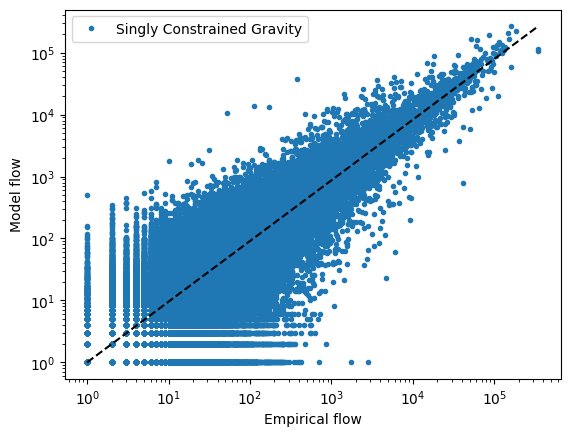

In [14]:
fdf=fdf.astype(int)
synth_fdf_gravity_single=synth_fdf_gravity_single.astype(int)
xy_gravity_single = fdf.merge(synth_fdf_gravity_single, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

plt.plot(xy_gravity_single[:,0], xy_gravity_single[:,1], '.', label='Singly Constrained Gravity')
x = np.logspace(0, np.log10((np.max(xy_gravity_single[:,0]))))
y = np.logspace(0, np.log10((np.max(xy_gravity_single[:,1]))))
plt.plot(x, y, '--k')
plt.xlabel('Empirical flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

#### Question 5 - Globally Constrained Gravitational Model

Generate the output with globally constrained gravity model with
a power law decaying function as the deterrence function type. Use the parameters
reported by Viboud, et al.in Table 2 for trips larger than 119 km.
Report the parameters of the model and show the scatter plot of data vs. the estimates of
synthetic flows created using the model.

In [32]:
gravity_globally_fitted = Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2], origin_exp=0.24, destination_exp=0.14, gravity_type="globally constrained")
print(gravity_globally_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2], origin_exp=0.24, destination_exp=0.14, gravity_type="globally constrained")


In [33]:
synth_fdf_gravity_global = gravity_globally_fitted.generate(nodes,
                                                        tile_id_column='county ID',
                                                        tot_outflows_column='tot_outflow',
                                                        relevance_column= 'population',
                                                        out_format='flows')

100%|██████████| 3140/3140 [00:06<00:00, 497.12it/s] 
/usr/local/lib/python3.10/dist-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/usr/local/lib/python3.10/dist-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


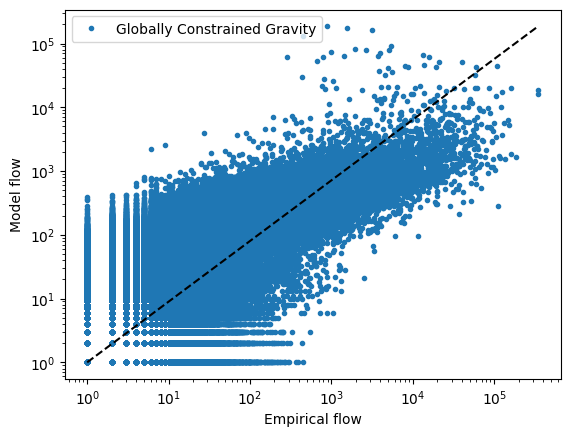

In [34]:
synth_fdf_gravity_global = synth_fdf_gravity_global.astype(int)
xy_gravity_global = fdf.merge(synth_fdf_gravity_global, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

plt.plot(xy_gravity_global[:,0], xy_gravity_global[:,1], '.', label='Globally Constrained Gravity')
x = np.logspace(0, np.log10((np.max(xy_gravity_global[:,0]))))
y = np.logspace(0, np.log10((np.max(xy_gravity_global[:,1]))))
plt.plot(x, y, '--k')
plt.xlabel('Empirical flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

#### Question 6 - Radiation Model

Apply the radiation model. Compare the data with the results of the radiation model by showing the scatter plot of the empirical flows based on the data vs. the estimates of synthetic flows created using the model.

In [19]:
from skmob.models.radiation import Radiation
np.random.seed(0)
radiation = Radiation()
rad_flows = radiation.generate(nodes, tile_id_column='county ID',  tot_outflows_column='tot_outflow', relevance_column='population', out_format='flows_sample')

100%|██████████| 3140/3140 [00:38<00:00, 82.17it/s] 
/usr/local/lib/python3.10/dist-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


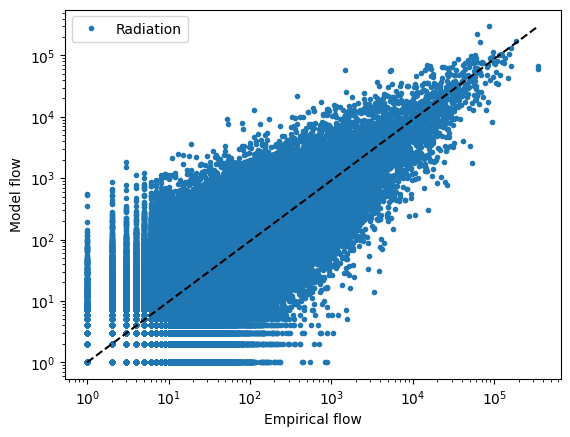

In [20]:
rad_flows=rad_flows.astype(int)
xy_radiation = fdf.merge(rad_flows, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
xy_radiation

plt.plot(xy_radiation[:,0], xy_radiation[:,1], '.', label='Radiation')
x = np.logspace(0, np.log10((np.max(xy_radiation[:,0]))))
y = np.logspace(0, np.log10((np.max(xy_radiation[:,1]))))
plt.plot(x, y, '--k')
plt.xlabel('Empirical flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

#### Question 7 - Error Metrics

Report the common part of commuters (CPC), the root mean square error (RMSE), R-squared value, and maximum error of each model. How do the performances of these models compare with the reported values in the paper by Lenormand, et al. for the US commuting flow data?

In [35]:
# compute gravity single metrics
cpc_gravity_single =2.0 * np.sum(np.minimum(xy_gravity_single[:, 0], xy_gravity_single[:, 1])) / (np.sum(xy_gravity_single[:, 0]) + np.sum(xy_gravity_single[:, 1]))
rmse_gravity_single = np.sqrt(sum((xy_gravity_single[:, 0] - xy_gravity_single[:, 1])**2)/xy_gravity_single[:,0].size)
r2_gravity_single = (np.corrcoef(xy_gravity_single[:, 0],xy_gravity_single[:, 1]))[0][1]**2
max_error_gravity_single = max(abs(xy_gravity_single[:,0] - xy_gravity_single[:,1]))

# compute gravity global metrics
cpc_gravity_global =2.0 * np.sum(np.minimum(xy_gravity_global[:, 0], xy_gravity_global[:, 1])) / (np.sum(xy_gravity_global[:, 0]) + np.sum(xy_gravity_global[:, 1]))
rmse_gravity_global = np.sqrt(sum((xy_gravity_global[:, 0] - xy_gravity_global[:, 1])**2)/xy_gravity_global[:,0].size)
r2_gravity_global = (np.corrcoef(xy_gravity_global[:, 0],xy_gravity_global[:, 1]))[0][1]**2
max_error_gravity_global = max(abs(xy_gravity_global[:,0] - xy_gravity_global[:,1]))

# compute radiation
cpc_radiation =2.0 * np.sum(np.minimum(xy_radiation[:, 0], xy_radiation[:, 1])) / (np.sum(xy_radiation[:, 0]) + np.sum(xy_radiation[:, 1]))
rmse_radiation = np.sqrt(sum((xy_radiation[:, 0] - xy_radiation[:, 1])**2)/xy_radiation[:,0].size)
r2_radiation = (np.corrcoef(xy_radiation[:, 0],xy_radiation[:, 1]))[0][1]**2
max_error_radiation = max(abs(xy_radiation[:,0] - xy_radiation[:,1]))

print("The Metrics for the Singly Constrained Gravity Model with Exponential Deterrence are:")
print(f'CPC = {cpc_gravity_single}')
print(f'RMSE = {rmse_gravity_single}')
print(f'R2 = {r2_gravity_single}')
print(f'Max Error = {max_error_gravity_single}')

print("\nThe Metrics for the Globally Constrained Gravity Model with Power-Function Deterrence are:")
print(f'CPC = {cpc_gravity_global}')
print(f'RMSE = {rmse_gravity_global}')
print(f'R2 = {r2_gravity_global}')
print(f'Max Error = {max_error_gravity_global}')

print("\nThe Metrics for the Radiation Model are:")
print(f'CPC = {cpc_radiation}')
print(f'RMSE = {rmse_radiation}')
print(f'R2 = {r2_radiation}')
print(f'Max Error = {max_error_radiation}')

The Metrics for the Singly Constrained Gravity Model with Exponential Deterrence are:
CPC = 0.7548147842006016
RMSE = 1376.0591357044593
R2 = 0.7369354995508939
Max Error = 233443

The Metrics for the Globally Constrained Gravity Model with Power-Function Deterrence are:
CPC = 0.3686699641638587
RMSE = 2650.7638571112275
R2 = 0.04193684174191507
Max Error = 330097

The Metrics for the Radiation Model are:
CPC = 0.6371990502563036
RMSE = 2251.2331524647625
R2 = 0.5645079255402387
Max Error = 279995


### Part 2

Build two undirected weighted graphs with the data and a trip distribution model of your choice, based on the models used in Problem 1. The goal is to analyze and compare their network properties.

#### Question 1

For both the data and your selected model, calculate the degree distributions of degree strengths or weighted degrees, similar to the figure below, which was extracted from the paper "The structure of interurban traffic: a weighted network analysis" presented in the lecture.


In [36]:
# Define helper functions (thank you Alben!)
def makeNetworkFromFiles(fedges,nodes,flow_i):
    ''' Generate a network from csv files.
    The first column of the nodes file is taken to be the id by default.
    The nodes file must contain columns named weight, source, and target.
    The deli parameter is the delimeter of the file. '''
    G = nx.Graph()
    fl=fedges
    for L in fl.index.values:
        o_n = fl['origin'][L]
        d_n = fl['destination'][L]
        if o_n != d_n:
            G.add_edge(fl['origin'][L],fl['destination'][L],weight=int(fl[flow_i][L]))
            dist = geopy.distance.geodesic((fl['O_latitude'][L],fl['O_longitude'][L]), (fl['D_latitude'][L],fl['D_longitude'][L])).km

            G[o_n][d_n]['distance'] = dist

    return G

def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

In [37]:
synth_fdf_gravity_single.head()

,origin,destination,flow
0,1001,1003,0
1,1001,1005,0
2,1001,1007,29
3,1001,1009,0
4,1001,1011,4


In [38]:
fdf.head()

,flow,origin,destination
0,7871,1001,1001
1,7,1001,1007
2,37,1001,1013
3,5,1001,1015
4,350,1001,1021


In [39]:
coordinates=nodes[['county ID','latitude','longitude']]

xy_grav_s=fdf.merge(synth_fdf_gravity_single, on=['origin', 'destination'])[['flow_x', 'flow_y','origin','destination']]
xy_grav_s.rename(columns={'flow_x':'flow_empirical', 'flow_y':'flow_model'}, inplace=True)

xy_gravity_single_o = xy_grav_s.merge(coordinates,left_on='origin',right_on='county ID')
xy_gravity_single_o.rename(columns={"latitude": "O_latitude", "longitude": "O_longitude"}, inplace=True)
xy_gravity_single_o.drop(columns=('county ID'), inplace=True)

xy_gravity_single_final = xy_gravity_single_o.merge(coordinates,left_on='origin',right_on='county ID')
xy_gravity_single_final.rename(columns={"latitude": "D_latitude", "longitude": "D_longitude"}, inplace=True)
xy_gravity_single_final.drop(columns=('county ID'), inplace=True)

xy_gravity_single_final.head()

,flow_empirical,flow_model,origin,destination,O_latitude,O_longitude,D_latitude,D_longitude
0,7,29,1001,1007,32.523283,-86.577176,32.523283,-86.577176
1,37,12,1001,1013,32.523283,-86.577176,32.523283,-86.577176
2,5,0,1001,1015,32.523283,-86.577176,32.523283,-86.577176
3,350,1175,1001,1021,32.523283,-86.577176,32.523283,-86.577176
4,8,0,1001,1031,32.523283,-86.577176,32.523283,-86.577176


In [40]:
g_empirical = makeNetworkFromFiles(xy_gravity_single_final,nodes,'flow_empirical')
g_model = makeNetworkFromFiles(xy_gravity_single_final,nodes,'flow_model')

In [41]:
wg_empirical=dict(g_empirical.degree(weight='weight')).values()
wg_model=dict(g_model.degree(weight='weight')).values()

weighted_empirical=remove_values_from_list(list(wg_empirical),0)
weighted_model=remove_values_from_list(list(wg_model),0)

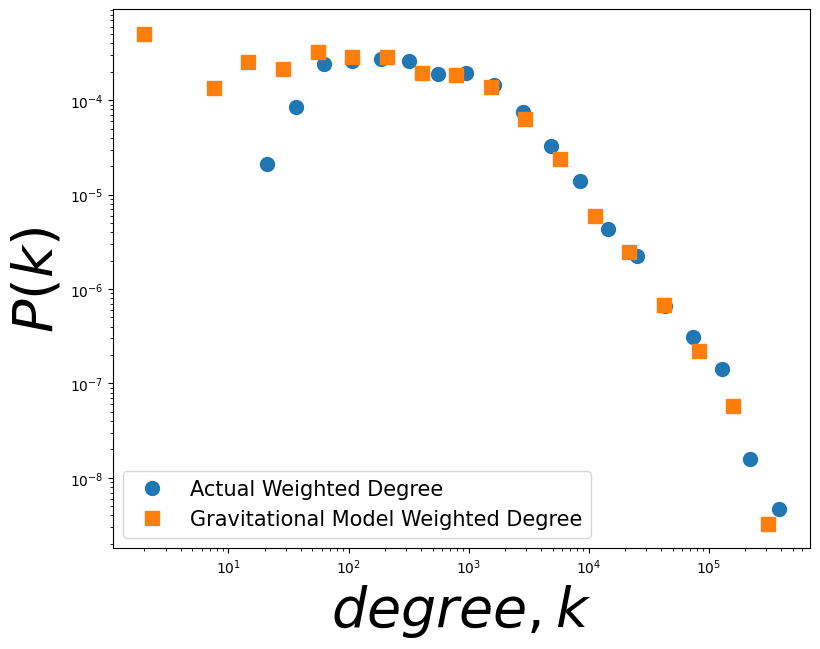

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches((9, 7))

n_bins = 20

out1_logBins = np.logspace(np.log10(min(weighted_empirical)), np.log10(max(weighted_empirical)),num=n_bins)
out1_logBinDensity, out_binedges = np.histogram(weighted_empirical, bins=out1_logBins, density=True)


out2_logBins = np.logspace(np.log10(min(weighted_model)), np.log10(max(weighted_model)),num=n_bins)
out2_logBinDensity, in_binedges = np.histogram(weighted_model, bins=out2_logBins, density=True)

ax.loglog(out1_logBins[:-1],out1_logBinDensity,'o', markersize=10,label='Actual Weighted Degree')
ax.loglog(out2_logBins[:-1],out2_logBinDensity,'s', markersize=10,label='Gravitational Model Weighted Degree')
ax.legend(fontsize=15, loc='lower left')


ax.set_xlabel('$degree, k$',fontsize=40)
ax.set_ylabel('$P(k)$',fontsize=40)
plt.savefig("distributions.eps",dpi=200,bbox_inches='tight')

In [43]:
def get_network_attributes(g_network: dict):
  """Takes a nx.Graph object as input and outputs standard attributes

  Inputs
    g_network (nx.Graph): Graph object from network x for which you wish to find
                          attr.

  Outputs
    min_degree: Kmin for the specified graph
    max_degree: Kmax for the specified graph
    avg_degree: <k> for the specified graph
    avg_std: Average standard deviation for the specified graph
    avg_cc: <CC> for the specified graph
    avg_sp: <L> average shortest path length for the specified graph
  """

  w_degrees = dict(g_network.degree(weight='weight')).values()
  min_degree = min(w_degrees)
  max_degree = max(w_degrees)
  avg_degree = sum(w_degrees) / len(g_network)

  std = nx.degree_pearson_correlation_coefficient(g_network, weight='weight')
  avg_clustering = nx.average_clustering(g_network, weight='weight')
  shortest_pl = nx.average_shortest_path_length(g_network, weight='weight')

  return min_degree, max_degree, std, avg_clustering, shortest_pl


In [44]:
emp_min, emp_max, emp_std, emp_cc, emp_l = get_network_attributes(g_empirical)
mod_min, mod_max, mod_std, mod_cc, mod_l = get_network_attributes(g_model)

In [46]:
emp_avg = sum(dict(g_empirical.degree(weight='weight')).values())/ len(g_empirical)
mod_avg = sum(dict(g_model.degree(weight='weight')).values())/ len(g_model)

In [49]:
print("For the empirical flows, the weighted network summaries are as follows:")
print(f"\tMinimum Degree: {emp_min}")
print(f"\tMaximum Degree: {emp_max}")
print(f"\tAverage Degree: {emp_avg}")
print(f"\tStandard Deviation: {emp_std}")
print(f"\tClustering Coefficient: {emp_cc}")
print(f"\tShortest Path: {emp_l}")

print("\nFor the model flows, the weighted network summaries are as follows:")
print(f"\tMinimum Degree: {mod_min}")
print(f"\tMaximum Degree: {mod_max}")
print(f"\tAverage Degree: {mod_avg}")
print(f"\tStandard Deviation: {mod_std}")
print(f"\tClustering Coefficient: {mod_cc}")
print(f"\tShortest Path: {mod_l}")


For the empirical flows, the weighted network summaries are as follows:
	Minimum Degree: 21
	Maximum Degree: 654161
	Average Degree: 11380.112101910829
	Standard Deviation: 0.031032923961900414
	Clustering Coefficient: 3.4649017622904004e-05
	Shortest Path: 5.716619557122943

For the model flows, the weighted network summaries are as follows:
	Minimum Degree: 0
	Maximum Degree: 601400
	Average Degree: 10993.48152866242
	Standard Deviation: 0.04688719284919046
	Clustering Coefficient: 3.393300272078111e-05
	Shortest Path: 0.0
